# SYNTACTIC PROCESSING USING MODIFIED VITERBI

The steps followed in this assignment:

1. Treebank dataset of NLTK with the 'universal' tagset is used - sampled into training and validation dataset.
2. Basic text and structure exploration pre and post sampling of data.
3. Creating HMM model on the data set.
    - Calculating Emission Probabaility: P(observation|state)
    - Calculating Transition Probability: P(state2|state1)
4. Developing the vanilla Viterbi algorithm for assigning POS tags without dealing with unknown words) 
5. Model Prediction and Evaluation on validation set.
6. Model Prediction and Evaluation on the Test file containing sample sentences.
7. Improving Viterbi algorithm by combining with Lexicon based approach using rules to handle unknown words.
8. Model Prediction and Evaluation on validation set.
9. Model Prediction and Evaluation with Test file.
10. Improving Viterbi algorithm by using only transitional probabilities for POS tagging of unknown words.
11. Model Prediction and Evaluation on validation set.
12. Model Prediction and Evaluation with Test Sentences.
13. Compare the tagging accuracies of the Vanilla Viterbi Algorithm with the modified algorithms.
14. List down cases which were incorrectly tagged by original POS tagger and were corrected by the modified viterbi.

### Reading and understanding the dataset

In [83]:
#Importing the required libraries
import nltk
import numpy as np
import pandas as pd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [84]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [85]:
#Viewing the first 10 ten tagged sentences
nltk_data[:10]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

### Exploratory Data Analysis

In [86]:
#Getting total number of tagged words in the corpus
tagged_words = [tup for sent in nltk_data for tup in sent]
print(len(tagged_words))

100676


In [87]:
#Checking the number of unique tags exists in Universal tag set
tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

In [88]:
#Viewing all the unique tags
unique_tags

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

From the dataset, we can get a list of all the abbreviations used:
1. VERB - verbs (all tenses and modes)
2. NOUN - nouns (common and proper)
3. PRON - pronouns
4. ADJ - adjectives
5. ADV - adverbs
6. ADP - adpositions (prepositions and postpositions)
7. CONJ - conjunctions
8. DET - determiners
9. NUM - cardinal numbers
10. PRT - particles or other function words
11. X - other: foreign words, typos, abbreviations
12. . - punctuation

In [89]:
# Frequency of tags in the data set
from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 28867,
         '.': 11715,
         'NUM': 3546,
         'ADJ': 6397,
         'VERB': 13564,
         'DET': 8725,
         'ADP': 9857,
         'CONJ': 2265,
         'X': 6613,
         'ADV': 3171,
         'PRT': 3219,
         'PRON': 2737})

In [90]:
#Checking the top three most frequently used tags
tag_counts.most_common(3)

[('NOUN', 28867), ('VERB', 13564), ('.', 11715)]

### Data Preparation for Model Building

In [91]:
# Splitting into train and validation sets using a sample size of 95:5 for training: validation sets
random.seed(1234)
train_set, validation_set = train_test_split(nltk_data,test_size=0.05,random_state=42)

print(len(train_set))
print(len(validation_set))
print(train_set[:10])

3718
196
[[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6.20', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('1991', 'NUM'), ('to', 'PRT'), ('7.272', 'NUM'), ('%', 'NOUN'), ('in', 'ADP'), ('2009', 'NUM'), ('.', '.')], [('``', '.'), ('They', 'PRON'), ('wer

In [92]:
#Creating a list of tagged words in the training set
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95589

In [93]:
#Creating a list of the words in the train set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Bank', 'of', 'New', 'England', "'s", 'shares', 'are', 'traded', '*-1', 'on']

In [94]:
#Finding the number of unique words in the train set
V = set(tokens)
print(len(V))

12109


In [95]:
#Finding the number of unique tags in the train set
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [96]:
#Printing the tags in the train set
print(T)

{'PRON', 'ADP', 'PRT', 'ADJ', 'ADV', 'VERB', 'NUM', 'CONJ', '.', 'X', 'DET', 'NOUN'}


### Building the vanilla Viterbi based POS tagger

In [97]:
# Computing P(w/t) and storing in T x V matrix where T is the tags and v represents the words
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))
w_given_t.shape

(12, 12109)

#### Computing the Emission Probabilities

In [98]:
#compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

#### Computing the Transitional Probabilities

In [99]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [100]:
# creating t x t transition matrix of tags each column is t2, each row is t1 thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [101]:
#convert the matrix to a dataframe for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,PRON,ADP,PRT,ADJ,ADV,VERB,NUM,CONJ,.,X,DET,NOUN
PRON,0.008021,0.022918,0.012223,0.074866,0.033995,0.480901,0.007257,0.004966,0.041253,0.092819,0.009549,0.211230
ADP,0.069128,0.017228,0.001498,0.105297,0.013162,0.008240,0.062921,0.000856,0.039486,0.034029,0.326378,0.321776
PRT,0.018960,0.021576,0.001635,0.086303,0.010134,0.402746,0.058516,0.002288,0.041517,0.013403,0.100360,0.242563
ADJ,0.000658,0.078986,0.010861,0.066645,0.004608,0.012342,0.020405,0.016949,0.065328,0.021392,0.005101,0.696725
ADV,0.015615,0.119601,0.013621,0.130233,0.081063,0.344518,0.030565,0.006312,0.136877,0.023588,0.067110,0.030897
VERB,0.036244,0.090493,0.031121,0.064649,0.082577,0.169189,0.022817,0.005588,0.035312,0.218005,0.133101,0.110904
NUM,0.001487,0.034790,0.027951,0.034196,0.002974,0.017544,0.184062,0.013381,0.118347,0.206661,0.003271,0.355338
CONJ,0.058658,0.054435,0.004693,0.116847,0.055842,0.153918,0.042234,0.000469,0.034256,0.007977,0.121539,0.349132
.,0.065389,0.091114,0.002339,0.044972,0.052078,0.088505,0.080500,0.057924,0.093812,0.026623,0.173502,0.223152
X,0.056087,0.142925,0.185787,0.016571,0.025175,0.203633,0.002709,0.010357,0.163799,0.076482,0.055131,0.061345


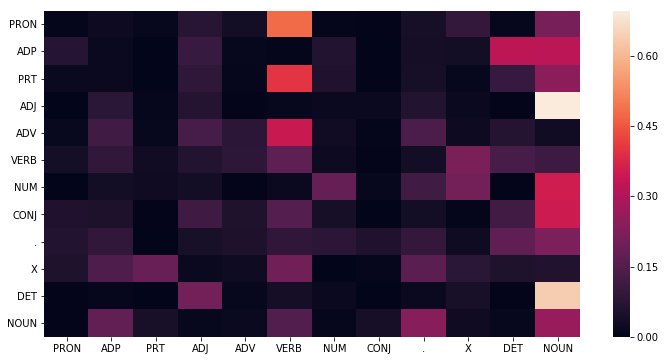

In [102]:
# Plotting heatmap for the tags dataframe
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(12, 6))
sns.heatmap(tags_df)
plt.show()

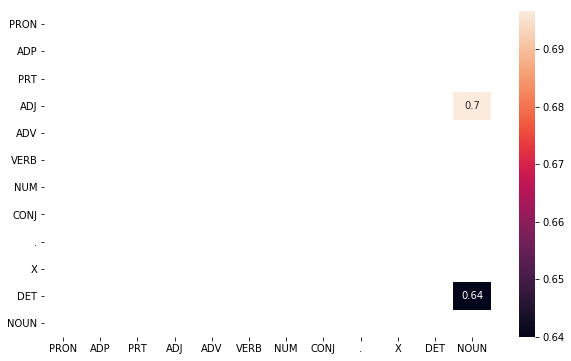

In [103]:
# Viewing only those tags where the P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(10, 6))
sns.heatmap(tags_frequent,annot=True)
plt.show()

The above heatmap shows  that adjective followed by a noun has the highest probability of 0.7.

#### VITERBI ALGORITHM

In [104]:
#Vanilla Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [105]:
# list of tagged words
validation_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in validation_set for tup in sent]
len(validation_tagged_words)

5087

In [106]:
# Running the Viterbi algorithm on the validation set and checking the time taken to run the algorithm
start = time.time()
tagged_seq_vanilla = Viterbi(validation_tagged_words)
end = time.time()
difference = end-start

In [107]:
#Printing the time taken as well as the tagged words
print("Time taken in seconds: ", difference)
print(tagged_seq_vanilla)

Time taken in seconds:  1584.2674443721771
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'PRON'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('pack

In [108]:
# accuracy
check = [i for i, j in zip(tagged_seq_vanilla, validation_run_base) if i == j] 
vanilla_viterbi_accuracy = len(check)/len(tagged_seq_vanilla)
vanilla_viterbi_accuracy

0.9131118537448398

In [109]:
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_vanilla, validation_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
print(incorrect_tagged_cases)

442
[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))], [('the', 'DET'), (('Overseas', 'PRON'), ('Overseas', 'NOUN'))], [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))], [('settled', 'VERB'), (('pre-1917', 'PRON'), ('pre-1917', 'ADJ'))], [('``', '.'), (('Unemployment', 'PRON'), ('Unemployment', 'NOUN'))], [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))], [('weekly', 'ADJ'), (('paycheck', 'PRON'), ('paycheck', 'NOUN'))], [('paycheck', 'NOUN'), (('reasonably', 'PRON'), ('reasonably', 'ADV'))], [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))], [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))], [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))], [('*-1', 'X'), (('Funded', 'PRON'), ('Funded', 'VERB'))], [('from', 'ADP'), (('Tokio', 'PRON'), ('Tokio', 'NOUN'))], [('medical', 'ADJ'), (('protocols', 'PRON'), ('protocols', 'NOUN'))], [('on', 'ADP'), (('preventative', 'PRON'), ('preventative', 'ADJ'))], [('it', 'PRON'), (('exist

We can see that several words are incorrectly tagged. Words such as 'Overseas','Unemployment','20.5','polarized' are incorrectly tagged as 'DET'.

In [110]:
# Let's read the test sentences sample file given to see and understand the pattern of words and tag sequence 
test_sentences = open("Test_sentences.txt", mode="r").read()
test_sentences_words=word_tokenize(test_sentences)
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_sentences_words)
end = time.time()
difference = end-start


In [111]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  60.51446843147278
[('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.'), ('Android', 'PRON'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRON'), ('worldwide', 'PRON'), ('on', 'ADP'), ('smartphones', 'PRON'), ('since', 'ADP'), ('2011', 'PRON'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRON'), ('.', '.'), ('Google', 'PRON'), ('and', 'CONJ'), ('Twitter', 'PRON'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRON'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'PRON'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRON'), ("'s", 'VERB'), ('firehose', 'PRON'), ('.', '.'), ('Twitter', 'PRON'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRON'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service

In [112]:
unknown_words = [word for word in test_sentences_words if word not in V]
print(len(unknown_words))
print(unknown_words)

36
['Android', 'Google', 'Android', 'OS', 'worldwide', 'smartphones', '2011', '2013', 'Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose', 'Twitter', 'online', 'interact', 'messages', 'tweets', 'domineering', 'personality', '2018', 'FIFA', 'Cup', '21st', 'FIFA', 'Cup', 'tournament', 'contested', 'Cup', 'trips', 'arriving', 'NASA', 'invited', 'ICESAT-2', 'Satellite']


As we have seen Vanilla viterbi is incapabe of identifying few words:
- Some Nouns like Android ,OS, Google, Twitter etc are identified them as 'PRON'
- Some verbs like arriving, contested are identified them as 'PRON'
- Some numbers like 2015, 2018 are identified them as 'PRON'

Its been observed that most of the incorrectly tagged words are those words which are not present in the training dataset and are assigned the first tag in the list of tags in the training set.
For unknown words the emission probablity is 0 hence the state probability will become 0 as (state probability = transition probability * emission probablity).Since all the state probability is 0 the pmax will be 0 and hence the index of list T will be 0 and the first tag will be assigned to the words.

### APPROACH 1 : USING RULE BASED TAGGER FOR UNKNOWN WORDS

In [113]:
# Applying Unigram tagger along with rule based tagging on our training dataset
patterns = [

    (r'.*(ously)$', 'ADV'), 
    (r'.*(ed|ing|es|ied|ould)$', 'VERB'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^([*0|-|$].*)','X'),    #  Unknown/Number having special characters *T*-117, 0
    (r'.*', 'NOUN')                    # nouns for any remaining words as it is the most frequently occuring tag
]



# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)


# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)


lexicon_tagger.evaluate(validation_set)

0.9532140750933753

By using the Unigram Tagger which backs off to the Rule based tagger on the training dataset, we see that we get a high accuract of 95%. We will now modify the viterbi algorithm by tagging the unknown words using the Rule based tagging approach.

In [114]:
# Storing all the unique words in the training dataset in a list
trained_words_list = list(V)
trained_words_list[:10]

['Circle',
 'Red',
 '23.4',
 'exclusion',
 'Steve',
 'Shokubai',
 'vision',
 'remorse',
 'toll',
 'cadet']

In [115]:
# Defining a function to tag the unknown words in the dataset using a rule based tagger.
def rule_based_tagger(word):
    patterns = [
        

    (r'.*(ously)$', 'ADV'), 
    (r'.*(ed|ing|es|ied|ould)$', 'VERB'),
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^([*0|-|$].*)','X'),    #  Unknown/Number having special characters *T*-117, 0
    (r'.*', 'NOUN')                    # nouns for any remaining words as it is the most frequently occuring tag
]
    
    rule_based_tagger = nltk.RegexpTagger(patterns)
    tag = rule_based_tagger.tag([word.lower()])[0][1]
    return tag

In [116]:
#Testing the rule based function on a random word
rule_based_tagger('hired')

'VERB'

In [117]:
# Viterbi Heuristic Modified such that all the unknown words are tagged by the definied rules
def RuleModifiedViterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if word not in trained_words_list and pmax == 0.0:            
            state_max = rule_based_tagger(word)
        else :
            state_max = T[p.index(pmax)] 
            
        state.append(state_max)
    return list(zip(words, state))

In [118]:
# # Running the Modified Viterbi algorithm on the validation set and checking the time taken to run the algorithm
start = time.time()
tagged_seq_rule = RuleModifiedViterbi(validation_tagged_words)
end = time.time()
difference = end-start

In [119]:
#Printing the time taken as well as the tagged words
print("Time taken in seconds: ", difference)
print(tagged_seq_rule)

Time taken in seconds:  1429.9039452075958
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('pack

In [120]:
# Checking accuracy for the Viterbi Algorithm modified using rule based approach
check = [i for i, j in zip(tagged_seq_rule, validation_run_base) if i == j] 
rule_viterbi_accuracy = len(check)/len(tagged_seq_rule)
rule_viterbi_accuracy

0.9547867112246904

In [121]:
#Checking the cases where the Modified algorithm incorrectly tagged the words
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_rule, validation_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
print(incorrect_tagged_cases)

230
[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))], [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))], [('settled', 'VERB'), (('pre-1917', 'NOUN'), ('pre-1917', 'ADJ'))], [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))], [('paycheck', 'NOUN'), (('reasonably', 'NOUN'), ('reasonably', 'ADV'))], [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))], [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))], [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))], [('on', 'ADP'), (('preventative', 'NOUN'), ('preventative', 'ADJ'))], [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))], [('*ICH*-2', 'X'), (('exists', 'NOUN'), ('exists', 'VERB'))], [('a', 'DET'), (('middle', 'NOUN'), ('middle', 'ADJ'))], [('.', '.'), (('Though', 'NOUN'), ('Though', 'ADP'))], [('chalk', 'NOUN'), (('first', 'ADJ'), ('first', 'ADV'))], [('on', 'ADP'), (('cross-border', 'NOUN'), ('cross-border', 'ADJ'))], [('of', 'ADP'), (('emigres', 'VERB'), ('emigres', 'NOUN'))], [(

In [122]:
#Running the Modified  Viterbi algorithm on the test sentences
start = time.time()
tagged_seq1 = RuleModifiedViterbi(test_sentences_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq1)

Time taken in seconds:  51.9831006526947
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'N

In [136]:
for i,j in enumerate(zip(tagged_seq,tagged_seq1,tagged_seq2)):
    if j[0]!=j[1]:
        print("Vanilla Viterbi-{} | Rule Based Viterbi-{}".format(j[0],j[1]))

Vanilla Viterbi-('Android', 'PRON') | Rule Based Viterbi-('Android', 'NOUN')
Vanilla Viterbi-('Google', 'PRON') | Rule Based Viterbi-('Google', 'NOUN')
Vanilla Viterbi-('Android', 'PRON') | Rule Based Viterbi-('Android', 'NOUN')
Vanilla Viterbi-('OS', 'PRON') | Rule Based Viterbi-('OS', 'NOUN')
Vanilla Viterbi-('worldwide', 'PRON') | Rule Based Viterbi-('worldwide', 'NOUN')
Vanilla Viterbi-('smartphones', 'PRON') | Rule Based Viterbi-('smartphones', 'VERB')
Vanilla Viterbi-('2011', 'PRON') | Rule Based Viterbi-('2011', 'NUM')
Vanilla Viterbi-('2013', 'PRON') | Rule Based Viterbi-('2013', 'NUM')
Vanilla Viterbi-('Google', 'PRON') | Rule Based Viterbi-('Google', 'NOUN')
Vanilla Viterbi-('Twitter', 'PRON') | Rule Based Viterbi-('Twitter', 'NOUN')
Vanilla Viterbi-('2015', 'PRON') | Rule Based Viterbi-('2015', 'NUM')
Vanilla Viterbi-('Google', 'PRON') | Rule Based Viterbi-('Google', 'NOUN')
Vanilla Viterbi-('Twitter', 'PRON') | Rule Based Viterbi-('Twitter', 'NOUN')
Vanilla Viterbi-("'s", '

The following words were tagged correctly by this approach(Using Rule based approach to tag unknown words):

1. <b>'Android'</b> is tagged correctly as 'NOUN'.
2. <b>'Google'</b> is tagged correctly as 'NOUN'.
3. <b>'OS'</b> is tagged correctly as 'NOUN'.
4. <b>'2011'</b> is tagged correctly as 'NUM'.
5. <b>'2013'</b> is tagged correctly as 'NUM'.
6. <b>'Twitter' </b>is tagged correctly as 'NOUN'.
7. <b> 'tweets'</b> is tagged correctly as 'NOUN'.
8. <b>'firehose'</b> is tagged correctly as 'NOUN'.
9. <b>'2018'</b> is tagged correctly as 'NUM'.
10. <b>'FIFA'</b> is tagged correctly as 'NOUN'.
11. <b>'cup'</b> is tagged correctly as 'NOUN'.
12. <b>'trips'</b> is tagged correctly as 'NOUN'.
13. <b>'domineering'</b> is tagged correctly as 'VERB'.
14. <b>'personality'</b> is tagged correctly as 'NOUN'.
15. <b>'contested'</b> is tagged correctly as 'VERB'.
16. <b>'NASA'</b> is tagged correctly as 'NOUN'.
17. <b>'invited'</b> is tagged correctly as 'VERB'.
18. <b>'ICESAT-2'</b> is tagged correctly as 'NOUN'.


### APPROACH 2 : USING TRANSITIONAL PROBABILITIES

In [123]:
#Modified Viterbi Heuristic using only transitional probabilities for unknown words
def ModifiedViterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        t_prob=[]
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            t_prob.append(transition_p)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if pmax==0.0:
            state_max=T[t_prob.index(max(t_prob))] 
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [124]:
# Tagging the validation set using the Modified Viterbi Algorithm
start = time.time()
tagged_seq_transitional = ModifiedViterbi(validation_tagged_words)
end = time.time()
difference = end-start

In [125]:
#Printing the time taken to tag the validation set as well as the tagged words
print("Time taken in seconds: ", difference)
print(tagged_seq_transitional)

Time taken in seconds:  1679.0212805271149
[('For', 'ADP'), ('the', 'DET'), ('Agency', 'NOUN'), ('for', 'ADP'), ('International', 'NOUN'), ('Development', 'NOUN'), (',', '.'), ('appropriators', 'NOUN'), ('approved', 'VERB'), ('$', '.'), ('200', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('in', 'ADP'), ('secondary', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('under', 'ADP'), ('an', 'DET'), ('expanded', 'VERB'), ('trade', 'VERB'), ('credit', 'NOUN'), ('insurance', 'NOUN'), ('program', 'NOUN'), (',', '.'), ('and', 'CONJ'), ('total', 'ADJ'), ('loan', 'NOUN'), ('guarantees', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('Overseas', 'NOUN'), ('Private', 'ADJ'), ('Investment', 'NOUN'), ('Corp.', 'NOUN'), ('are', 'VERB'), ('increased', 'VERB'), ('*-3', 'X'), ('by', 'ADP'), ('$', '.'), ('40', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('over', 'ADP'), ('fiscal', 'ADJ'), ('1989', 'NUM'), ('as', 'ADP'), ('part', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('same', 'ADJ'), ('Poland', 'NOUN'), ('pack

In [126]:
# Checking the accuracy for the Modified viterbi Algorithm
check = [i for i, j in zip(tagged_seq_transitional, validation_run_base) if i == j] 
Modified_viterbi_accuracy = len(check)/len(tagged_seq_transitional)
Modified_viterbi_accuracy

0.9388637703951248

In [127]:
# Finding all the words that were incorrectly tagged by Modified Viterbi
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_transitional, validation_run_base)) if j[0]!=j[1]]
print(len(incorrect_tagged_cases))
print(incorrect_tagged_cases)

311
[[('expanded', 'VERB'), (('trade', 'VERB'), ('trade', 'NOUN'))], [('Overseas', 'NOUN'), (('Private', 'ADJ'), ('Private', 'NOUN'))], [('settled', 'VERB'), (('pre-1917', 'X'), ('pre-1917', 'ADJ'))], [('the', 'DET'), (('purchasing', 'NOUN'), ('purchasing', 'VERB'))], [('paycheck', 'NOUN'), (('reasonably', 'NOUN'), ('reasonably', 'ADV'))], [(',', '.'), (('though', 'ADP'), ('though', 'ADV'))], [('such', 'ADJ'), (('close', 'NOUN'), ('close', 'ADJ'))], [('acquiring', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))], [('from', 'ADP'), (('Tokio', 'DET'), ('Tokio', 'NOUN'))], [('on', 'ADP'), (('preventative', 'DET'), ('preventative', 'ADJ'))], [('$', '.'), (('20.5', 'NOUN'), ('20.5', 'NUM'))], [('become', 'VERB'), (('polarized', 'X'), ('polarized', 'VERB'))], [(',', '.'), (('so', 'ADV'), ('so', 'ADP'))], [('a', 'DET'), (('middle', 'NOUN'), ('middle', 'ADJ'))], [('.', '.'), (('Though', 'NOUN'), ('Though', 'ADP'))], [('totaled', 'VERB'), (('154.2', 'X'), ('154.2', 'NUM'))], [('Since', 'ADP'), (('c

In [128]:
# Tagging the test sentences using the Modified Viterbi Algorithm
start = time.time()
tagged_seq2 = ModifiedViterbi(test_sentences_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)
print(tagged_seq2)

Time taken in seconds:  65.4496328830719
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.'), ('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN')

In [135]:
#comparing the POS tags assigned by the Vanilla Viterbi algorithm versus those assigned by the Modified Viterbi
for i,j in enumerate(zip(tagged_seq,tagged_seq2)):
    if j[0]!=j[1]:
        print("Vanilla Viterbi-{} | Modified Viterbi using Transitional prob-{}".format(j[0],j[1]))

Vanilla Viterbi-('Android', 'PRON') | Modified Viterbi using Transitional prob-('Android', 'NOUN')
Vanilla Viterbi-('Google', 'PRON') | Modified Viterbi using Transitional prob-('Google', 'DET')
Vanilla Viterbi-('Android', 'PRON') | Modified Viterbi using Transitional prob-('Android', 'NOUN')
Vanilla Viterbi-('OS', 'PRON') | Modified Viterbi using Transitional prob-('OS', 'NOUN')
Vanilla Viterbi-('worldwide', 'PRON') | Modified Viterbi using Transitional prob-('worldwide', 'NOUN')
Vanilla Viterbi-('smartphones', 'PRON') | Modified Viterbi using Transitional prob-('smartphones', 'DET')
Vanilla Viterbi-('2011', 'PRON') | Modified Viterbi using Transitional prob-('2011', 'DET')
Vanilla Viterbi-('2013', 'PRON') | Modified Viterbi using Transitional prob-('2013', 'DET')
Vanilla Viterbi-('Google', 'PRON') | Modified Viterbi using Transitional prob-('Google', 'NOUN')
Vanilla Viterbi-('Twitter', 'PRON') | Modified Viterbi using Transitional prob-('Twitter', 'NOUN')
Vanilla Viterbi-('2015', 'PR

The following were tagged correctly by this approach(using transitional probability for tagging unknown words):

1. <b>Android'</b> is tagged correctly as 'NOUN'.
2. <b>'OS'</b> is correctly tagged as 'NOUN'.
3. <b>'Twitter'</b> is correctly tagged as 'NOUN'.
4. <b>'FIFA'</b>  is correctly tagged as 'NOUN'.
5. <b>'cup' </b> is correctly tagged as 'NOUN'.
6. <b>'trips'</b>  is correctly tagged as 'NOUN'.
7. <b>'personality' </b> is correctly tagged as 'NOUN'.
8. <b>'NASA' </b> is correctly tagged as 'NOUN'.

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [129]:
print("Vannila Viterbi Accuracy: {}".format(vanilla_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: {}".format(rule_viterbi_accuracy))
print("Modified Viterbi Accuracy: {}".format(Modified_viterbi_accuracy))

Vannila Viterbi Accuracy: 0.9131118537448398
Rule Based Viterbi Accuracy: 0.9547867112246904
Modified Viterbi Accuracy: 0.9388637703951248


<table>
  <thead>
    <tr>
      <th>Approach</th>
      <th>Accuracy (%)</th>
        <th>Number of words tagged wrong </th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Vanilla Viterbi</td>
      <td>91.3</td>
        <td>442</td>
    </tr>
    <tr>
      <td>Approach 1: Modified Viterbi using Rule Based Approach</td>
      <td>95.4</td>
        <td>230</td>
    </tr>
      <tr>
      <td>Approach 2: Modified Viterbi using Transitional probability to tag unknown words</td>
      <td>93.9</td>
        <td>311</td>
    </tr>
  </tbody>
</table>


#### The Modified Viterbi using rule based approach performs the best amongst the three algorithms.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [130]:
# # Creating a list for the POS tags assigned by all three algorithms for the unknown words in the test sentence 
display_list=[]
for i in range(len(tagged_seq)):
        if tagged_seq[i][0] in unknown_words:
            tags_for_word=[tagged_seq[i][0],tagged_seq[i][1],tagged_seq1[i][1],tagged_seq2[i][1]]
            display_list.append(tags_for_word)

In [131]:
#Viewing the list
display_list[:10]

[['Android', 'PRON', 'NOUN', 'NOUN'],
 ['Google', 'PRON', 'NOUN', 'DET'],
 ['Android', 'PRON', 'NOUN', 'NOUN'],
 ['OS', 'PRON', 'NOUN', 'NOUN'],
 ['worldwide', 'PRON', 'NOUN', 'NOUN'],
 ['smartphones', 'PRON', 'VERB', 'DET'],
 ['2011', 'PRON', 'NUM', 'DET'],
 ['2013', 'PRON', 'NUM', 'DET'],
 ['Google', 'PRON', 'NOUN', 'NOUN'],
 ['Twitter', 'PRON', 'NOUN', 'NOUN']]

In [132]:
# Looking at the POS tags by all three algorithms for the words in the test sentence 
from IPython.display import HTML, display
import tabulate
headers = ['Word','POS tag (Vanilla Viterbi)','POS tag Approach-1(Rule Based)','POS tag Approach-2(Transition Prob)']
display(HTML(tabulate.tabulate(display_list,headers, tablefmt='html')))

Word,POS tag (Vanilla Viterbi),POS tag Approach-1(Rule Based),POS tag Approach-2(Transition Prob)
Android,PRON,NOUN,NOUN
Google,PRON,NOUN,DET
Android,PRON,NOUN,NOUN
OS,PRON,NOUN,NOUN
worldwide,PRON,NOUN,NOUN
smartphones,PRON,VERB,DET
2011,PRON,NUM,DET
2013,PRON,NUM,DET
Google,PRON,NOUN,NOUN
Twitter,PRON,NOUN,NOUN


### Words correctly tagged by Modified Viterbi Algorithms

1. MODIFIED VITERBI USING RULE BASED APPROACH FOR UNKNOWN WORDS - The following words were tagged correctly by this algorithm:
  - <b>'Android'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'Google'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'OS'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'2011'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NUM' by this approach.
  - <b>'2013'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NUM' by this approach.
  - <b>'Twitter' </b>was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b> 'tweets'</b> was tagged as 'PROn' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'firehose'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'2018'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NUM' by this approach.
  - <b>'FIFA'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'cup'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'trips'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'domineering'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'VERB' by this approach.
  - <b>'personality'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'contested'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'VERB' by this approach.
  - <b>'NASA'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'invited'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'VERB' by this approach.
  - <b>'ICESAT-2'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.



2. MODIFIED VITERBI USING TRANSITIONAL PROBABILITIES FOR UNKNOWN WORDS - The following words were tagged correctly by this 
algorithm:
  - <b>'Android'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'OS'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'Twitter'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'FIFA'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'cup'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'trips'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'personality'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
  - <b>'NASA'</b> was tagged as 'PRON' by vanilla Viterbi but got corrected to 'NOUN' by this approach.
 

We can see that the Modified Viterbi using Rule Based tagger for tagging unknown words performs much better than the second approach.